In [ ]:
#installs
!pip install xlrd
!pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
#imports
import pandas as pd
import numpy as np
from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.umath import *
import math
import scipy as sc
import matplotlib.pyplot as plt
from scipy import optimize
from numpy import arange
from numpy.ma.core import tan
from scipy.optimize import curve_fit
import csv
from scipy.stats import norm
import matplotlib.ticker as ticker

In [ ]:
#Definitionen
n_Spule = 130
r_Spule = ufloat(16.2e-2, 0.2e-2)
mu0 = 1.25663706212e-6

In [ ]:
#methods

def add_column_with_constant(array, constant_value):
    # Get the shape of the input array
    shape = array.shape
    
    # Create a column with constant values
    constant_column = np.full((shape[0], 1), constant_value)
    
    # Append the constant column to the input array
    new_array = np.concatenate((constant_column, array), axis=1)
    
    return new_array

def sinusfunct(x, a, b, phi, c):
    return (a*np.sin(b*x+phi) +c)

def logreg(x, a, b, c):
  return a/(1+b*np.exp(c*x))

def quadradic(x, a, b, c):
  return a*np.power(x,2) + b*x + c

def line(x, a, b):
  return a*x + b

def daten_fitten(funct, x_data, y_data, genauigkeit, p): #Step4/5
    #fiten
    pars, cov = curve_fit(f=funct, xdata=x_data, ydata=y_data, p0=p, bounds=[-np.inf, np.inf], maxfev=500000)
    # Get the standard deviations of the parameters (square roots of the diagonal of the covariance)
    stdevs = np.sqrt(np.diag(cov))
    print('Fitparameter')
    print(pars)
    print('zugehörige Uncertainty')
    print(stdevs)
    #datensets
    xfit = np.linspace(min(x_data), max(x_data), genauigkeit)
    yfit = funct(xfit, *pars)
    return pars, stdevs, xfit, yfit

def filter_array_lower_limit(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column > filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array

def filter_array_upper_limit(array, filtervalue, index):
    # Get the second column of the input array
    second_column = array[:, index]
    
    # Find the indices where the values are greater than 10
    indices = np.where(second_column < filtervalue)
    
    # Filter the array based on the indices
    filtered_array = array[indices]
    
    return filtered_array


In [ ]:
#Daten einlesen
data = pd.read_excel('data.xlsx')

#converte dataframe to array
data = data.values

columns = data[:, 2:6]
mean = np.mean(columns, axis=1)
std = np.std(columns, axis=1)

data = np.delete(data, np.s_[2:6], axis=1)

#data to uarray with uncertainties
uncertainty_array = np.array([0.1, 0.005])
udata = unp.uarray(data, uncertainty_array)
mean_array = unp.uarray(mean/2,std/2)

udata = np.column_stack((udata, mean_array))

In [ ]:
#calculate H
H_values = np.zeros(len(udata))
H_values = unp.uarray(H_values, 0)
for i in range(len(udata)):
  H_values[i] = (8*n_Spule*udata[i,1])/(np.sqrt(125)*r_Spule)

udata = np.column_stack((udata, H_values))

#calculate 1/H^2
H2_values = np.zeros(len(udata))
H2_values = unp.uarray(H2_values, 0)
for i in range(len(udata)):
  H2_values[i] = 1/((udata[i,3])**2)

udata = np.column_stack((udata, H2_values))

#calculate x-axis
X_values = np.zeros(len(udata))
X_values = unp.uarray(X_values, 0)
for i in range(len(udata)):
  X_values[i] = (((mu0*udata[i,2]*np.float_power(10,-2))**2)*np.float_power(10,9))/(2*udata[i,0])

udata = np.column_stack((udata, X_values))
print(udata[:,2])

[5.09375+/-0.062186714819163866 4.84375+/-0.03247595264191648
 4.6375+/-0.021650635094611275 4.1937500000000005+/-0.027243118397128986
 3.98125+/-0.06465050270492882 3.8125+/-0.06495190528383286
 3.3812499999999996+/-0.06931585316505896 3.33125+/-0.03247595264191652
 3.18125+/-0.040983990776887545 2.9812499999999997+/-0.07781187248742967
 4.893750000000001+/-0.010825317547305638
 4.6499999999999995+/-0.0306186217847898 4.38125+/-0.05962120008855923
 4.09375+/-0.054126587736527204 3.9749999999999996+/-0.02499999999999991
 3.69375+/-0.036975498644372655 3.3625+/-0.11924240017711821
 3.39375+/-0.027243118397129115 3.125+/-0.030618621784789617
 2.875+/-0.06373774391990984]


In [ ]:
#split array into 2 arrays to seperate diffrent voltage
splitter_value = 275
index_voltage = 0
udata_250 = filter_array_upper_limit(udata, splitter_value, index_voltage)
udata_300 = filter_array_lower_limit(udata, splitter_value, index_voltage)
print(udata_300)

[[300.0+/-0.1 1.567+/-0.005 4.893750000000001+/-0.010825317547305638
  899.7716695239153+/-11.473308237026579
  1.2351945607594798e-06+/-3.1500809390432783e-08
  6.303068645049429e-09+/-2.7964696019988392e-11]
 [300.0+/-0.1 1.64+/-0.005 4.6499999999999995+/-0.0306186217847898
  941.6882820799113+/-11.97503385586872
  1.1276794530059245e-06+/-2.8680402815435093e-08
  5.690813903864004e-09+/-7.496803702182053e-11]
 [300.0+/-0.1 1.744+/-0.005 4.38125+/-0.05962120008855923
  1001.4050999679058+/-12.692007562771096
  9.971957119050157e-07+/-2.5277313881199516e-08
  5.0520140391459195e-09+/-1.375085784251101e-10]
 [300.0+/-0.1 1.837+/-0.005 4.09375+/-0.054126587736527204
  1054.8057159639009+/-13.335019888932049
  8.987834170244357e-07+/-2.272512285527534e-08
  4.410736492486947e-09+/-1.1664468153264016e-10]
 [300.0+/-0.1 1.945+/-0.005 3.9749999999999996+/-0.02499999999999991
  1116.819334539895+/-14.083630208217368
  8.017411084528211e-07+/-2.022068376677531e-08
  4.158557818926636e-09+/-5.

Steigung: (1.9+/-0.4)e+02


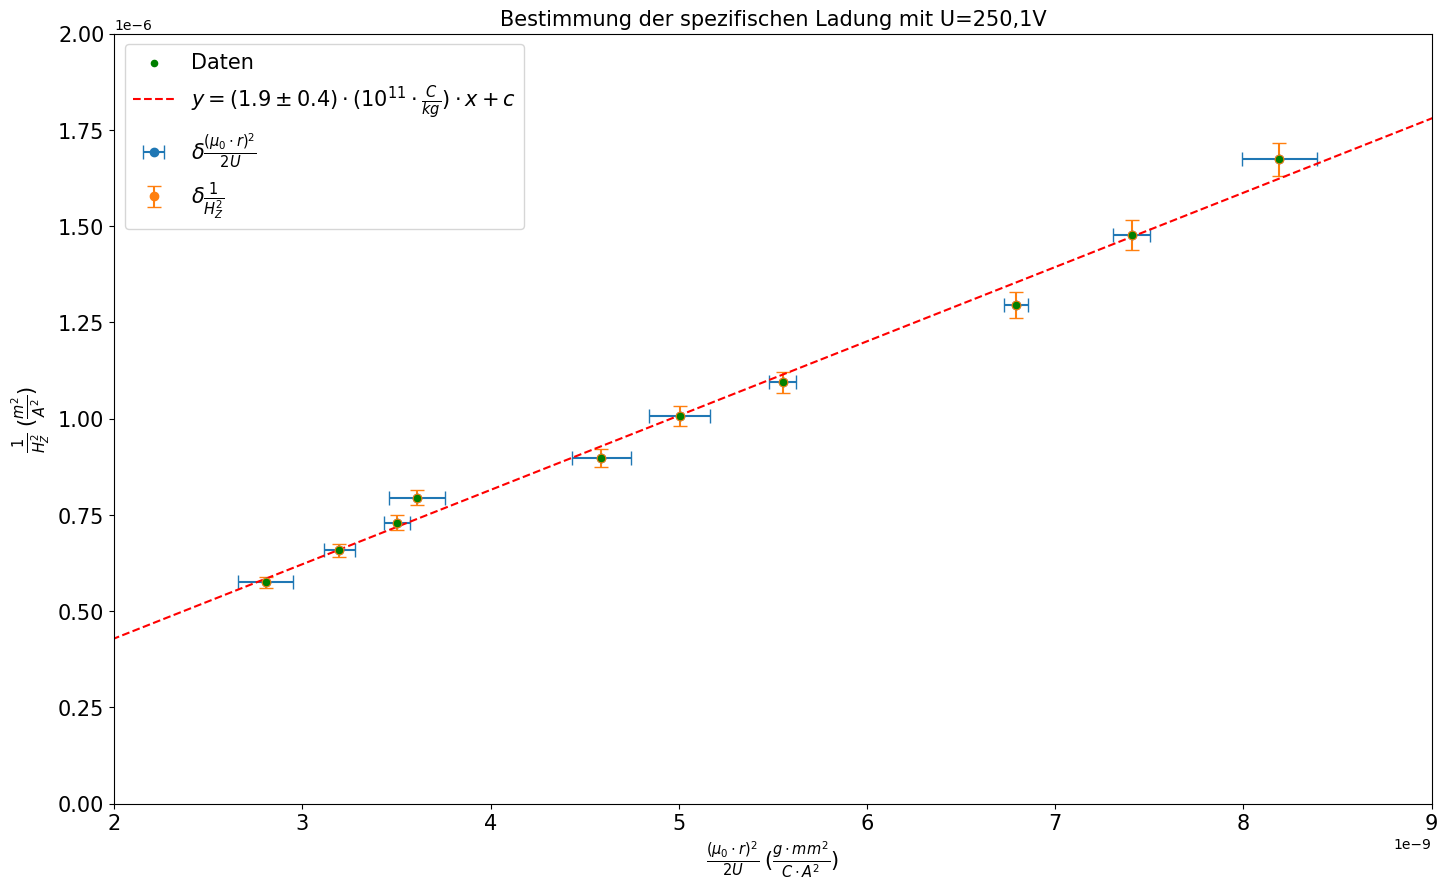

In [ ]:
#r/H-Diagramm-250
plt.subplots(1,1,figsize=(17, 10));

x = [float(i[5].nominal_value) for i in udata_250]
y = [float(i[4].nominal_value) for i in udata_250]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[5].std_dev) for i in udata_250]
y_error = [float(i[4].std_dev) for i in udata_250]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δ\frac{(μ_{0} \cdot r)^2}{2U}$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\frac{1}{H_{Z}^2}$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-1, 100)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.1f \pm %.1f) \cdot (10^{11} \cdot \frac{C}{kg}) \cdot x + c$'%(steigung.nominal_value*np.float_power(10,-2), steigung.std_dev*np.float_power(10,-2)))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'$\frac{(μ_{0} \cdot r)^2}{2U} \:  (\frac{g \cdot mm^2}{C \cdot A^2})$', fontsize=15)
plt.ylabel(r'$\frac{1}{H_{Z}^2} \:  (\frac{m^2}{A^2})$', fontsize=15)
plt.title('Bestimmung der spezifischen Ladung mit U=250,1V', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0.000000002, 0.000000009, 0, 0.000002]) #Achsenanpassung
plt.show()

Steigung: 187+/-27


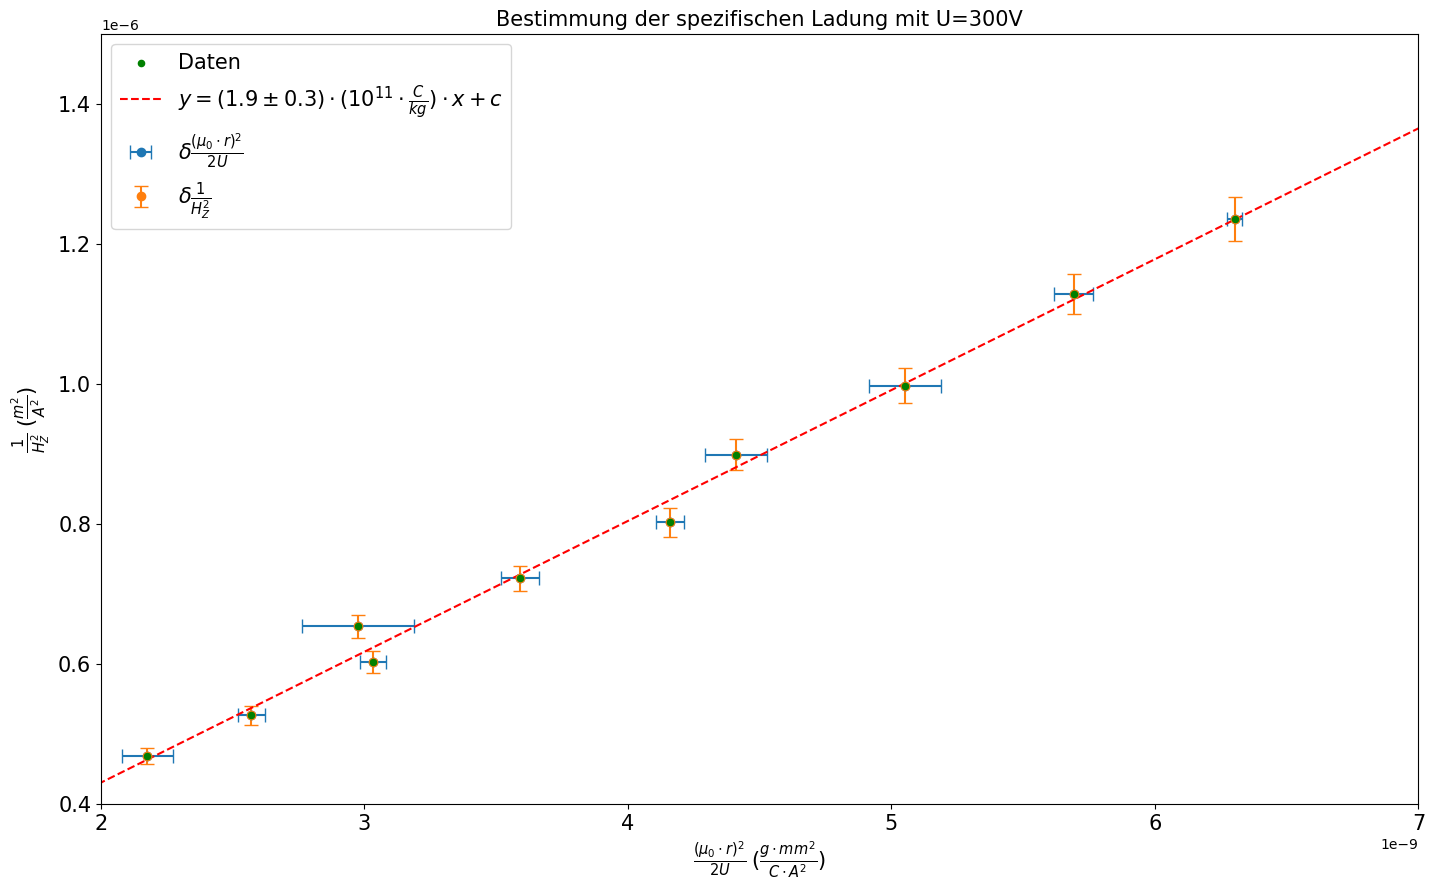

In [ ]:
#r/H-Diagramm-300
plt.subplots(1,1,figsize=(17, 10));

x = [float(i[5].nominal_value) for i in udata_300]
y = [float(i[4].nominal_value) for i in udata_300]

plt.scatter(x, y, label = 'Daten', color='green', s=20, zorder= 5)

x_error = [float(i[5].std_dev) for i in udata_300]
y_error = [float(i[4].std_dev) for i in udata_300]

plt.errorbar(x, y, xerr=x_error, fmt='o', capsize=5, label = r'$δ\frac{(μ_{0} \cdot r)^2}{2U}$')
plt.errorbar(x, y, yerr=y_error, fmt='o', capsize=5, label = r'$δ\frac{1}{H_{Z}^2}$')

popt, pcov = sc.optimize.curve_fit(line, x, y)
a, b = popt
x_line = arange(-1, 100)
y_line = line(x_line, a, b)
perr = np.diag(pcov)
steigung = ufloat(popt[0], pcov[0][0])
Schnitt = ufloat(popt[1], pcov[1][1])

plt.plot(x_line, y_line, '--', color='red', label = r'$y = (%.1f \pm %.1f) \cdot (10^{11} \cdot \frac{C}{kg}) \cdot x + c$'%(steigung.nominal_value*np.float_power(10,-2), steigung.std_dev*np.float_power(10,-2)))
print('Steigung:', steigung)


# Add axis labels and a title
plt.xlabel(r'$\frac{(μ_{0} \cdot r)^2}{2U} \:  (\frac{g \cdot mm^2}{C \cdot A^2})$', fontsize=15)
plt.ylabel(r'$\frac{1}{H_{Z}^2} \:  (\frac{m^2}{A^2})$', fontsize=15)
plt.title('Bestimmung der spezifischen Ladung mit U=300V', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Display the plot
plt.legend(loc = 'upper left', fontsize=15)
plt.axis([0.000000002, 0.000000007, 0.0000004, 0.0000015]) #Achsenanpassung
plt.show()